In [1]:
import modelling_lib_rodrixx as mod
import preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

import mlflow

In [2]:
dataframes_path = os.path.join(os.getcwd(), 'dataframes')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [3]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1982_to_2022.pkl'))

In [4]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,1,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,...,20,5,8,0.695,82,3,0.927,31,0.045,690
1,2,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,...,10,13,15,0.561,82,10,0.963,0,0.000,690
2,3,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,...,48,34,36,0.341,82,36,0.622,0,0.000,690
3,4,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,...,22,68,47,0.768,82,1,0.646,0,0.000,690
4,5,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,...,45,40,35,0.768,82,1,0.829,0,0.000,690


In [5]:
cols_tot = [col for col in df.columns if '_tot' in col]
cols_to_drop = ['Rk', 'G', 'GS', 'GT', 'Votes', 'MaxVotes', 'Tm']
cols_to_drop += cols_tot
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
col_to_ohe = 'Pos'

In [6]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('OHE', prep.OHE(col_to_ohe)),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [7]:
df = pipe_clean.fit_transform(df)

In [8]:
df.head()

,,Age,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,2P_pg,2PA_pg,...,VORP_rank,%W,%W_rank,%G,Share,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG
Rk,Season,,,,,,,,,,,,,,,,,,,,,
1,1982,34,35.2,9.9,17.1,0.579,0.0,0.0,0.000,9.9,17.1,...,8,0.695,3,0.927,0.045,1,0,0,0,0
2,1982,27,30.3,6.4,13.0,0.494,0.0,0.0,0.000,6.4,13.0,...,15,0.561,10,0.963,0.000,1,0,0,0,0
3,1982,22,28.8,7.5,16.1,0.465,0.5,1.4,0.352,7.0,14.7,...,36,0.341,36,0.622,0.000,0,0,0,1,0
4,1982,22,10.6,1.5,4.2,0.357,0.1,0.3,0.294,1.4,3.8,...,47,0.768,1,0.646,0.000,0,0,0,0,1
5,1982,33,31.9,4.5,9.6,0.472,0.1,0.2,0.375,4.4,9.4,...,35,0.768,1,0.829,0.000,0,0,1,0,0


In [9]:
len(df[df.index.get_level_values(1) > 2016]) / len(df)

0.18186460874992907

In [10]:
val_df = df[df.index.get_level_values(1) > 2016]
dev_df = df[df.index.get_level_values(1) <= 2016]

In [11]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .4)

In [12]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [13]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val], ignore_index = True))

MinMaxScaler()

In [14]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [15]:
# pipe_scale = Pipeline(steps = [
#     ('Scaler', scaler),
#     ('ArrayToDf', prep.ArrayToDataFrame(columns = X_train.columns))
# ])

In [16]:
# for key, dataset in datasets.items():
#     index_param = dataset.index
#     pipe_scale.set_params(**{'ArrayToDf__index': index_param})
#     datasets[key] = pipe_scale.transform(dataset)

In [17]:
mlflow.set_experiment('NBA MVP prediction XGBoost')

<Experiment: artifact_location='file:///C:/Users/marcr/OneDrive/Documents/Data%20Science/NBA%20Project/mlruns/5', experiment_id='5', lifecycle_stage='active', name='NBA MVP prediction XGBoost', tags={}>

In [37]:
param_grid = {
    'max_depth': [3], 
    'colsample_bytree': [.7],
    'subsample': [.7],
    'n_estimators': [150],
    'learning_rate': [.2]
    }

In [38]:
with mlflow.start_run():
    estimator = xgb.XGBRegressor(random_state = 23)

    model = GridSearchCV(estimator, param_grid, scoring = ('neg_root_mean_squared_error', 'r2'), refit = 'neg_root_mean_squared_error', cv = 10, verbose = 2)

    model.fit(X_train, y_train)

    results = model.cv_results_

    cv_scores = mod.get_cv_scores(results)

    best_model, best_params, best_cv_score = mod.retrieve_best(model)

    predicted_targets = mod.predict_model(best_model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_xgb(best_params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(best_model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_feature_importances_xgb(best_model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=  20.6s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=  11.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=  16.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=  15.5s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=  15.6s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=  23.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   4.9s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   8.0s
[CV] END colsample_

2022/10/15 21:49:55 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\marcr\AppData\Local\Temp\tmpemdnl8gi\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


In [39]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.013047,0.015570,0.030893
R2,0.993017,0.970672,0.692300


In [40]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)

In [41]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Player,Share,PredShare
Rk,Season,,,
458,2017,Russell Westbrook,0.879,0.380323
173,2017,James Harden,0.746,0.569465
261,2017,Kawhi Leonard,0.495,0.390207
221,2017,LeBron James,0.330,0.301668
425,2017,Isaiah Thomas,0.080,0.111595
98,2017,Stephen Curry,0.051,0.238890
16,2017,Giannis Antetokounmpo,0.007,0.049373
453,2017,John Wall,0.007,0.103516
100,2017,Anthony Davis,0.002,0.107405


,,Player,Share,PredShare
Rk,Season,,,
195,2018,James Harden,0.955,0.819247
249,2018,LeBron James,0.731,0.433366
122,2018,Anthony Davis,0.441,0.201178
298,2018,Damian Lillard,0.205,0.211313
508,2018,Russell Westbrook,0.075,0.191631
16,2018,Giannis Antetokounmpo,0.074,0.078875
143,2018,Kevin Durant,0.065,0.334120
130,2018,DeMar DeRozan,0.032,0.005290
7,2018,LaMarcus Aldridge,0.006,0.045166


,,Player,Share,PredShare
Rk,Season,,,
18,2019,Giannis Antetokounmpo,0.932,0.676808
207,2019,James Harden,0.768,0.570581
184,2019,Paul George,0.352,0.105545
270,2019,Nikola Jokić,0.210,0.187302
124,2019,Stephen Curry,0.173,0.212962
305,2019,Damian Lillard,0.068,0.246374
155,2019,Joel Embiid,0.049,0.080298
150,2019,Kevin Durant,0.025,0.202334
301,2019,Kawhi Leonard,0.013,0.270382


,,Player,Share,PredShare
Rk,Season,,,
13,2020,Giannis Antetokounmpo,0.952,0.702192
251,2020,LeBron James,0.746,0.446912
199,2020,James Harden,0.363,0.477808
134,2020,Luka Dončić,0.198,0.103830
294,2020,Kawhi Leonard,0.166,0.146495
123,2020,Anthony Davis,0.081,0.313371
396,2020,Chris Paul,0.026,-0.014755
297,2020,Damian Lillard,0.023,0.156162
262,2020,Nikola Jokić,0.018,0.071876


,,Player,Share,PredShare
Rk,Season,,,
263,2021,Nikola Jokić,0.961,0.556520
146,2021,Joel Embiid,0.580,0.170800
116,2021,Stephen Curry,0.449,0.169275
12,2021,Giannis Antetokounmpo,0.345,0.339170
396,2021,Chris Paul,0.138,-0.024385
130,2021,Luka Dončić,0.042,0.144714
297,2021,Damian Lillard,0.038,0.197982
421,2021,Julius Randle,0.020,0.105815
439,2021,Derrick Rose,0.010,-0.000205


,,Player,Share,PredShare
Rk,Season,,,
290,2022,Nikola Jokić,0.875,0.630851
162,2022,Joel Embiid,0.706,0.283132
12,2022,Giannis Antetokounmpo,0.595,0.252182
59,2022,Devin Booker,0.216,0.173097
141,2022,Luka Dončić,0.146,0.273479
526,2022,Jayson Tatum,0.043,0.068640
390,2022,Ja Morant,0.010,0.202498
126,2022,Stephen Curry,0.004,0.103600
438,2022,Chris Paul,0.002,0.097501


No contenders results:


Player  Share  PredShare
Rk  Season                                     
1   2020         Steven Adams    0.0   0.006937
2   2020          Bam Adebayo    0.0   0.007255
    2021         Jaylen Adams    0.0   0.000762
    2022         Steven Adams    0.0   0.009068
3   2018         Steven Adams    0.0   0.065782
...                       ...    ...        ...
593 2022      Justise Winslow    0.0   0.000640
596 2022    Robert Woodard II    0.0   0.000640
599 2022         Moses Wright    0.0   0.000920
602 2022           Trae Young    0.0   0.059390
603 2022       Omer Yurtseven    0.0   0.000107

[1763 rows x 3 columns]

In [42]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Player,Share,PredShare
Rk,Season,,,
35,2020,Bradley Beal,0.0,0.162002
38,2021,Bradley Beal,0.0,0.128529
87,2022,Jimmy Butler,0.0,0.105806
89,2019,Clint Capela,0.0,0.105925
177,2020,Rudy Gobert,0.0,0.130329
195,2022,Rudy Gobert,0.0,0.104827
244,2021,Kyrie Irving,0.0,0.182200
396,2018,Chris Paul,0.0,0.164827
434,2017,Karl-Anthony Towns,0.0,0.128517


<AxesSubplot:title={'center':'Most important features'}, xlabel='Feature', ylabel='Importance coefficient'>

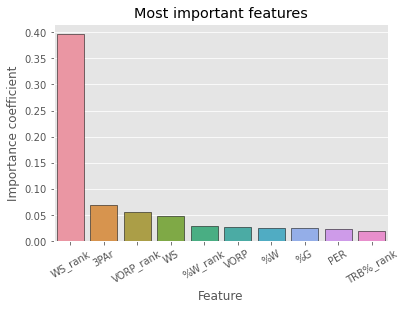

In [43]:
mod.display_feature_importances_xgb(best_model)

In [44]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)

(<Figure size 2880x2880 with 6 Axes>, <Figure size 2880x2880 with 6 Axes>)

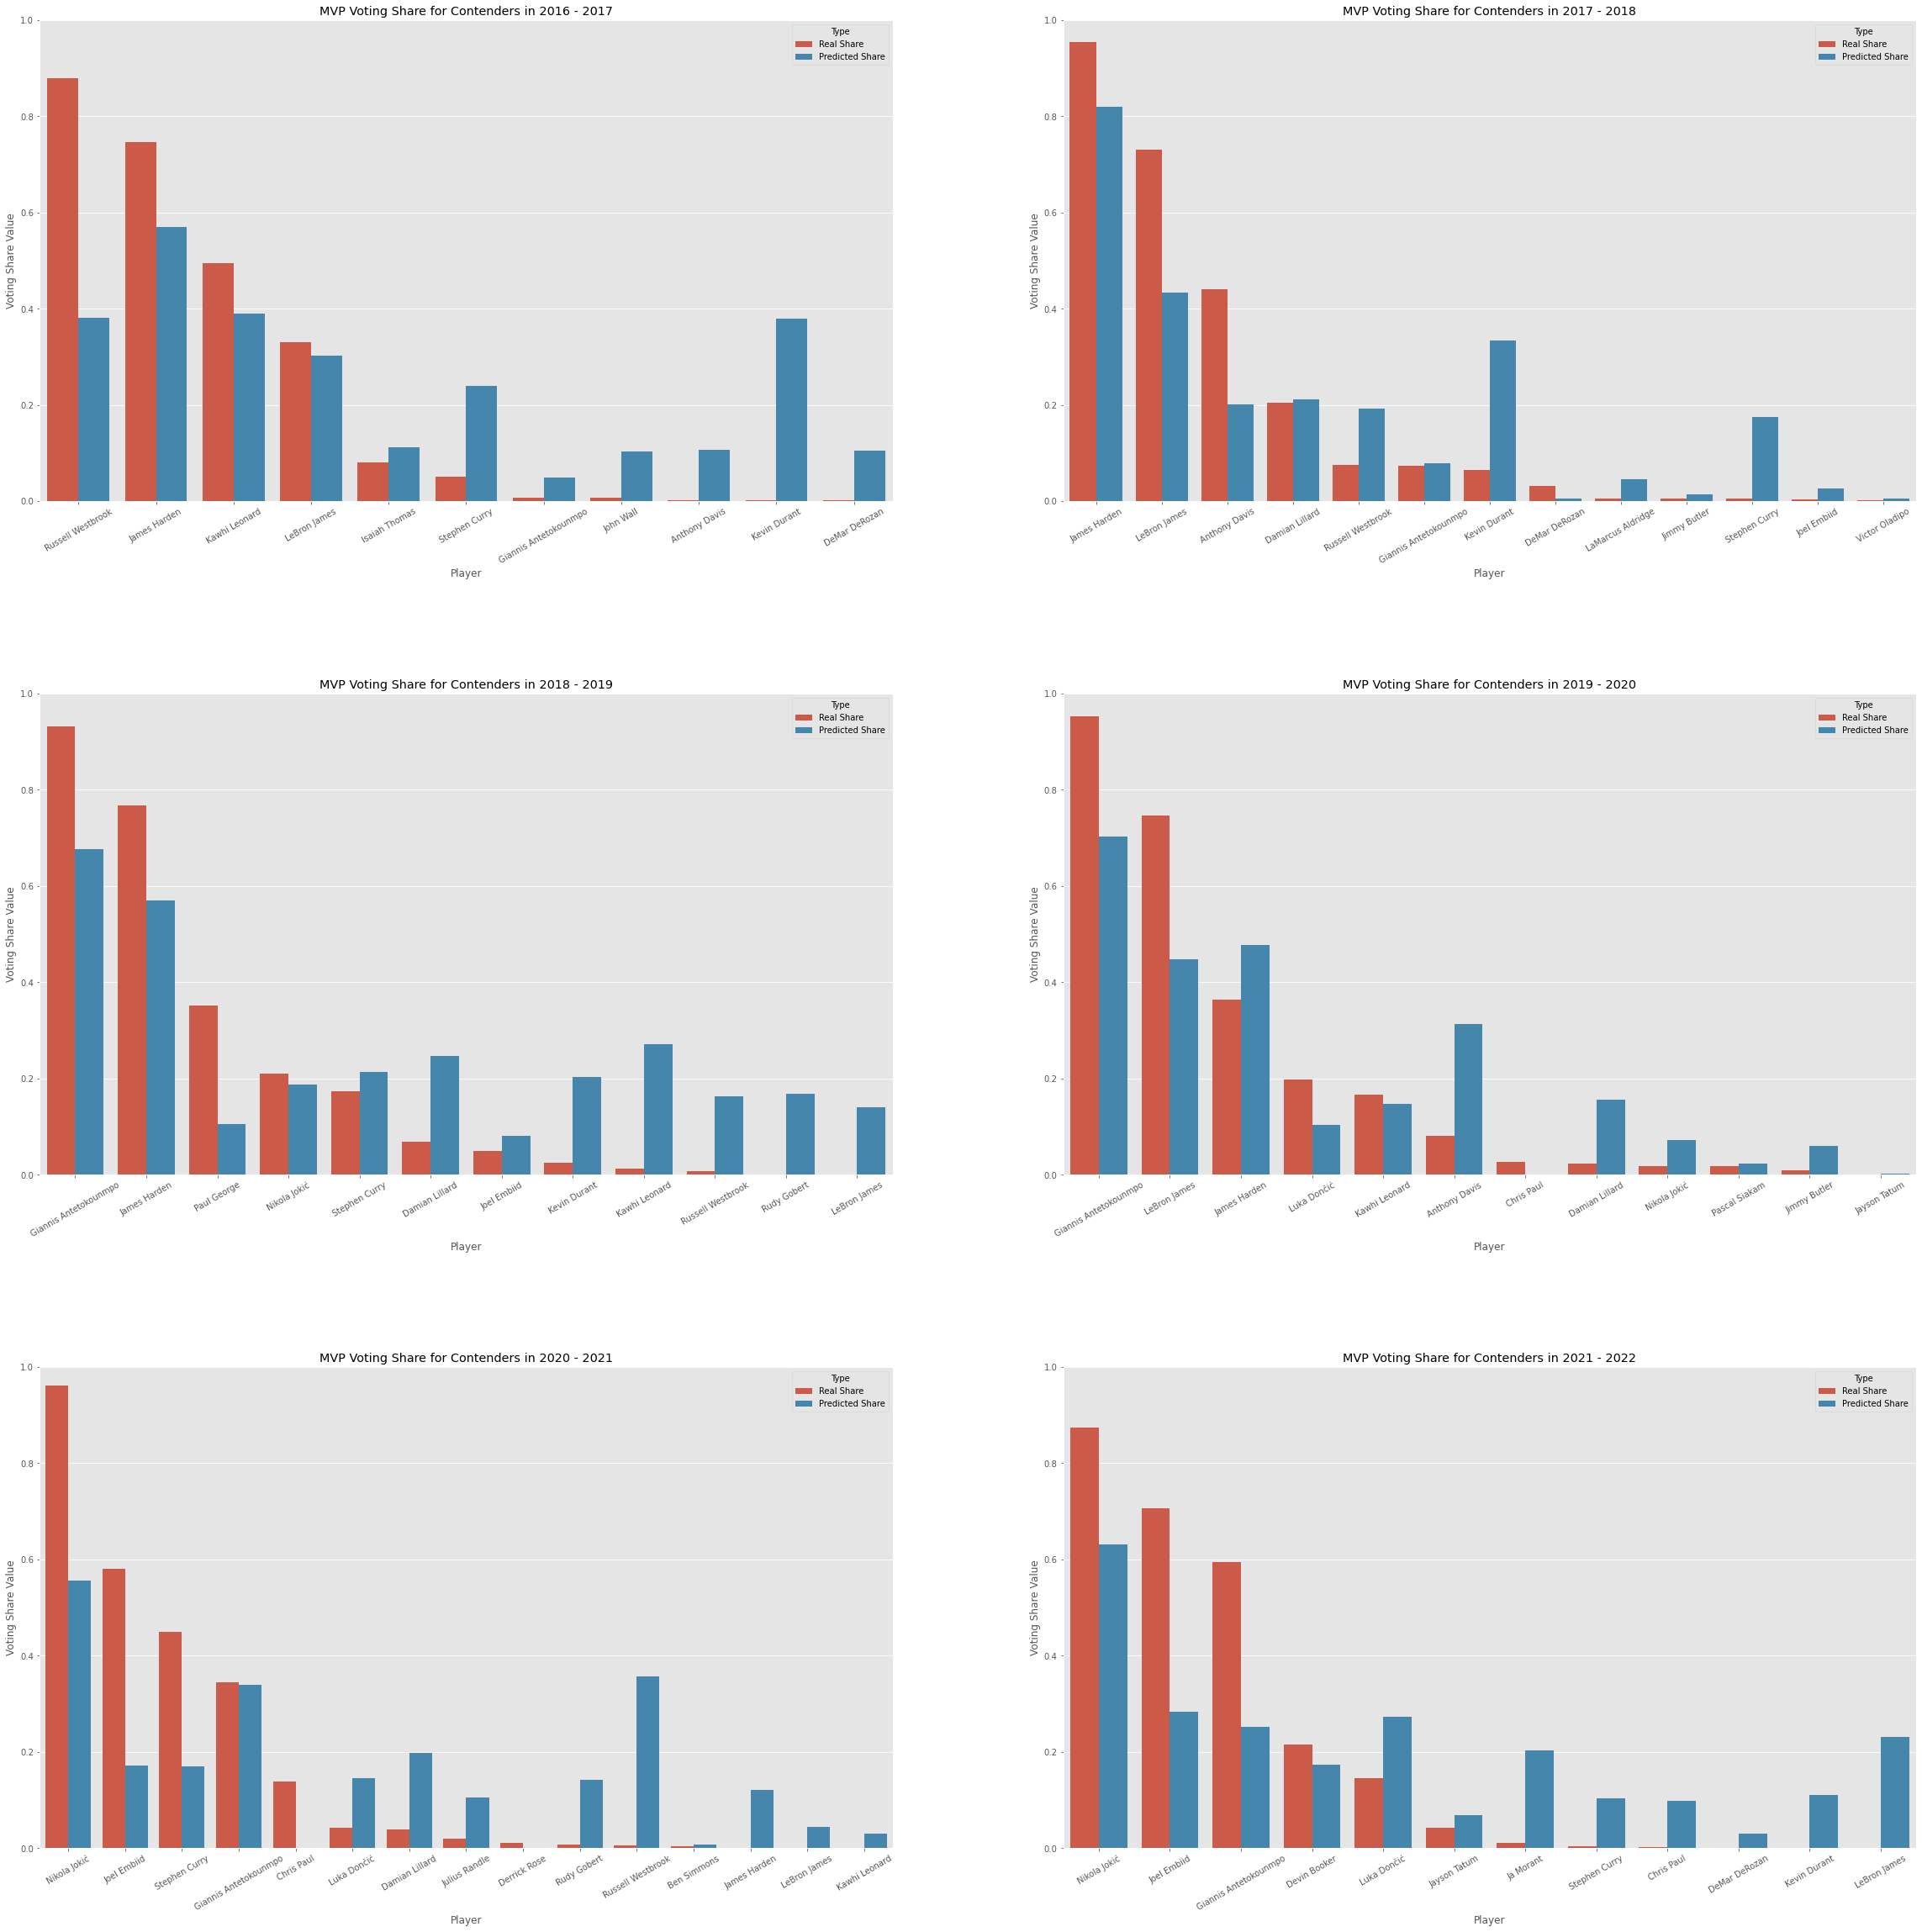

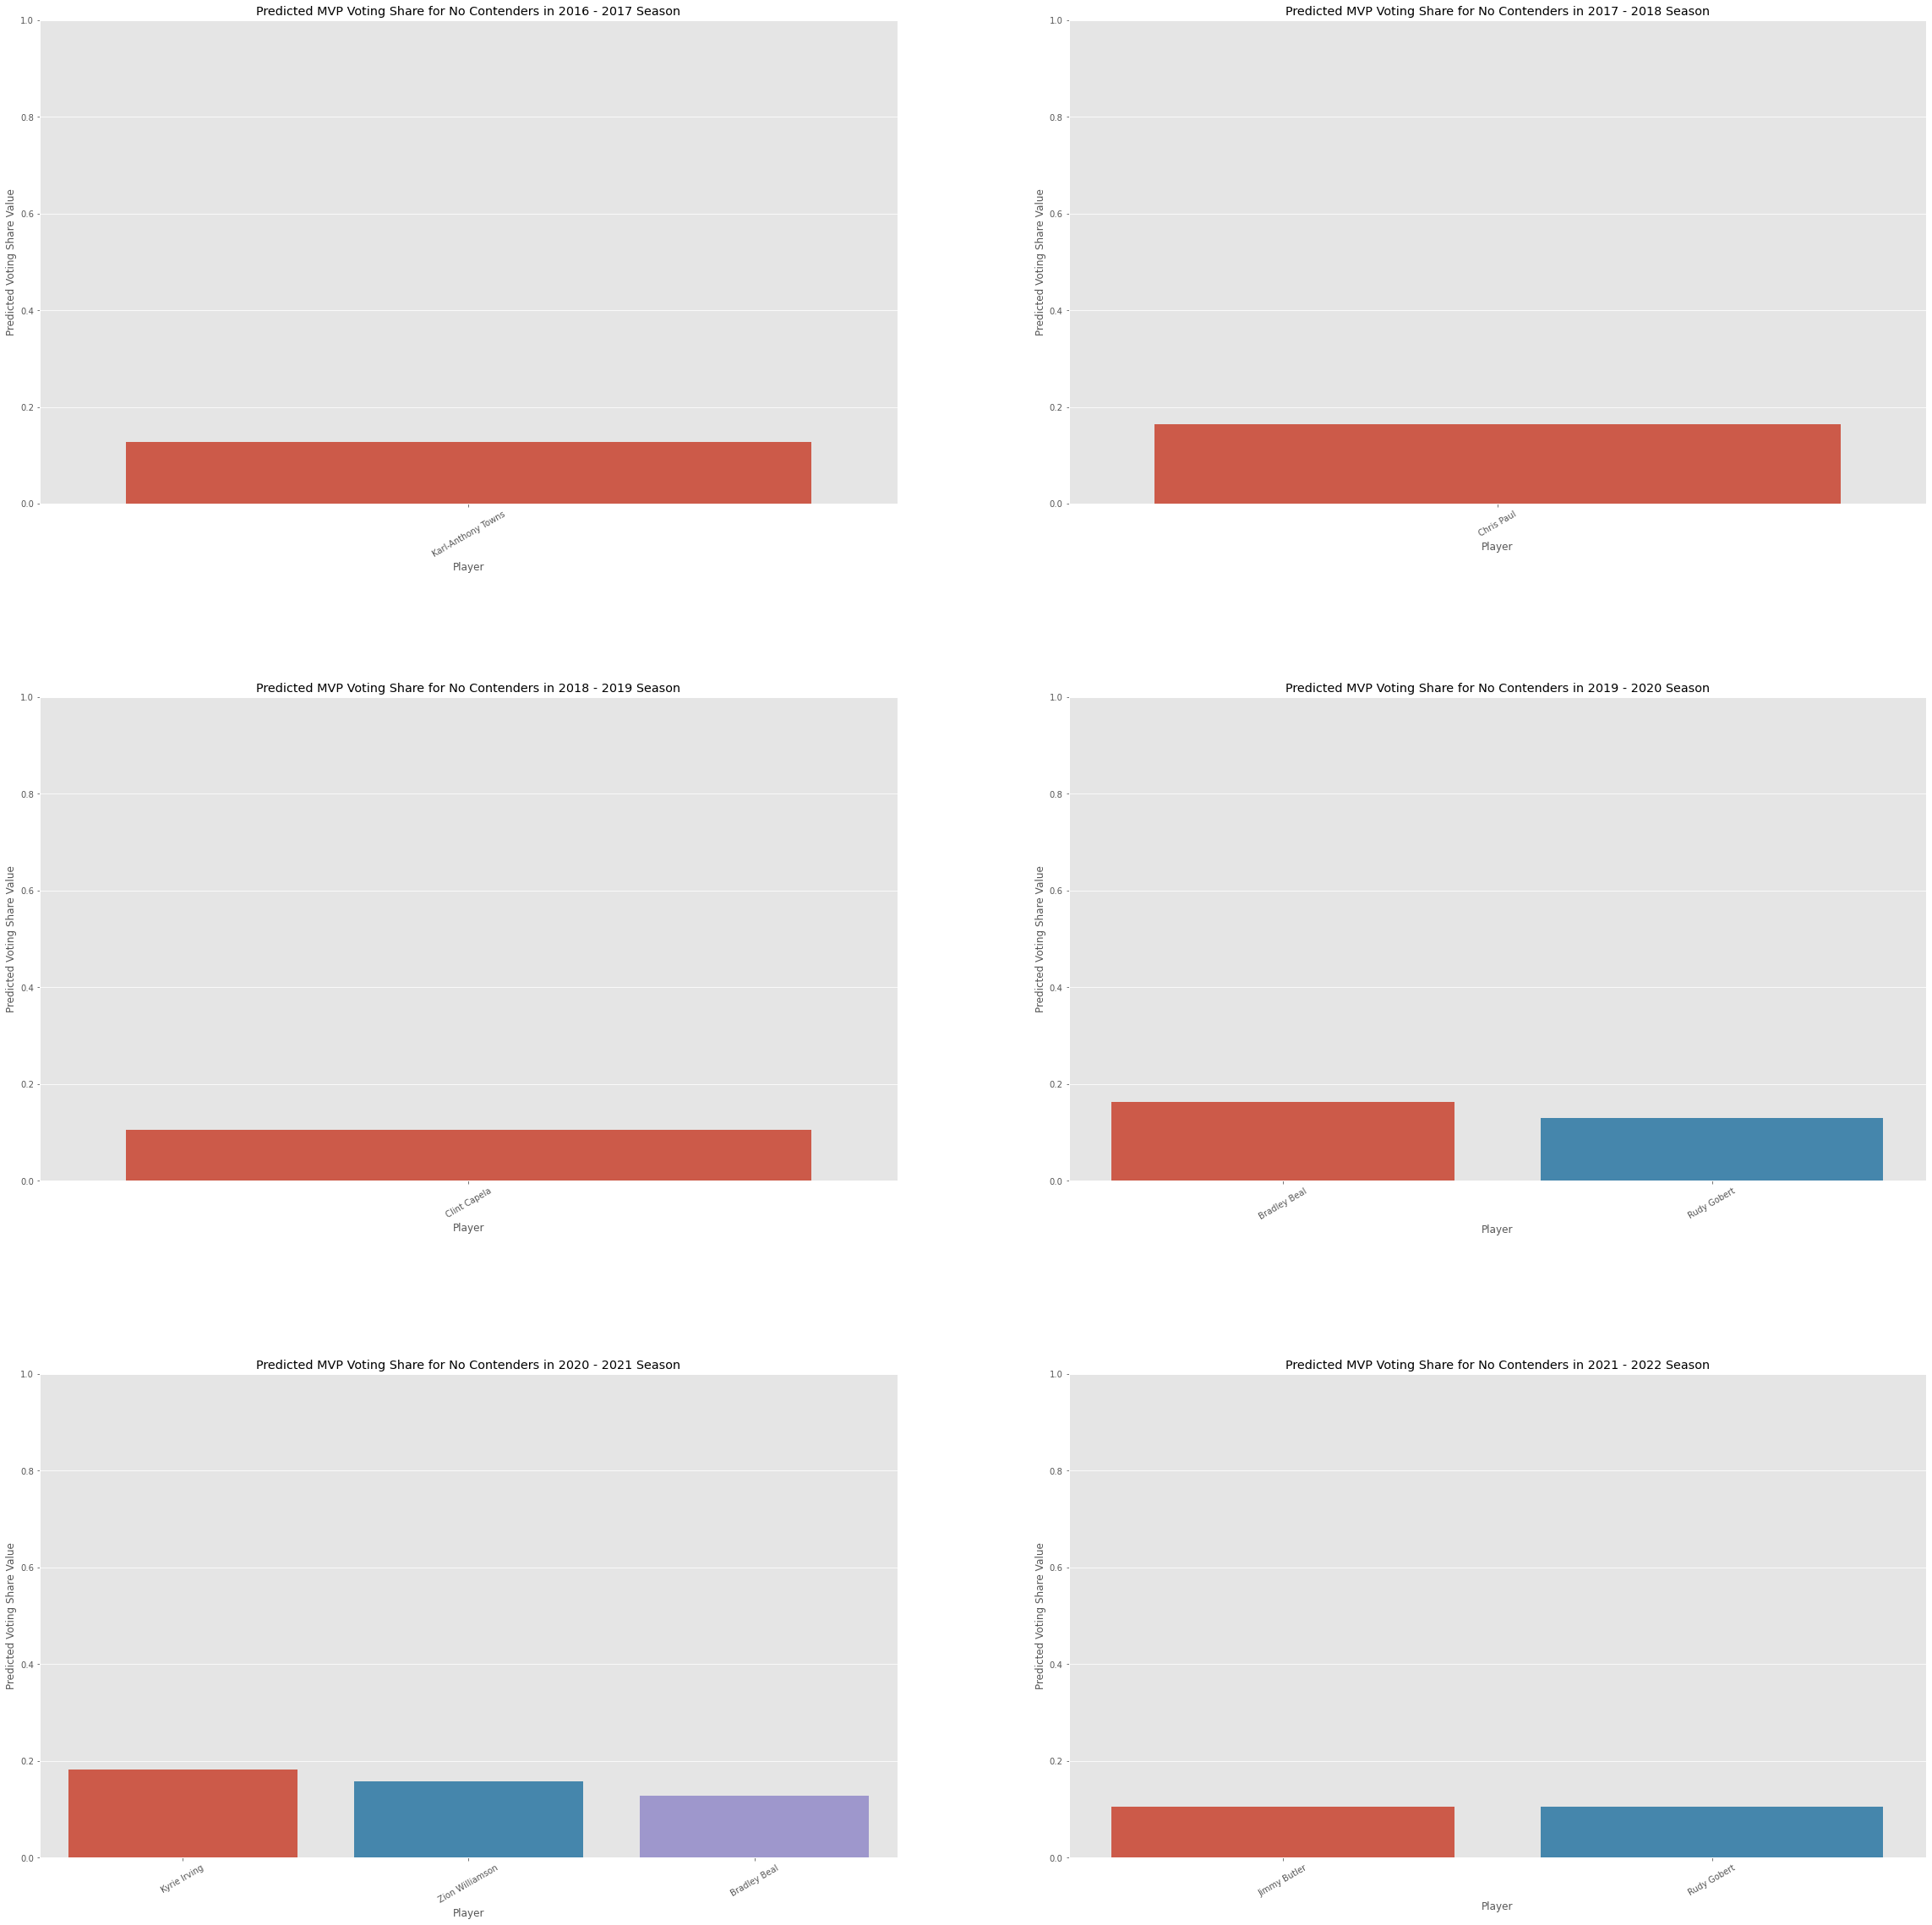

In [45]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)